In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
%matplotlib inline


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [32]:
# Define the path to store the dataset
data_root = './data/celeba'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Download the dataset
celeba_train = datasets.CelebA(root=data_root, split='train', target_type='attr', download=True, transform=transform)


Files already downloaded and verified


In [33]:
# List of attributes in order
celeba_attributes = celeba_train.attr_names
print("List of attributes in CelebA:")
for idx, attr in enumerate(celeba_attributes):
    print(f"{idx}: {attr}")


List of attributes in CelebA:
0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young
40: 


In [34]:
# Extract the 'Smiling' attribute
smiling_attr = celeba_train.attr[:, 31]

# Check unique values
unique_values = np.unique(smiling_attr)
print(f"Unique values for 'Smiling' attribute: {unique_values}")


Unique values for 'Smiling' attribute: [0 1]


In [35]:
class CelebADataset(Dataset):
    def __init__(self, celeba_dataset, domain_attribute=31, transform=None):
        """
        Args:
            celeba_dataset (Dataset): The CelebA dataset.
            domain_attribute (int): Index of the attribute to define domains.
                                    31 corresponds to 'Smiling'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.celeba = celeba_dataset
        self.transform = transform
        self.attr = self.celeba.attr
        self.domain_attribute = domain_attribute
        
        # Split into two domains based on the attribute encoding
        self.domain_A_indices = np.where(self.attr[:, self.domain_attribute] == 1)[0]  # Smiling
        if -1 in self.attr[:, self.domain_attribute]:
            self.domain_B_indices = np.where(self.attr[:, self.domain_attribute] == -1)[0]  # Not Smiling
            label_neg = -1
        elif 0 in self.attr[:, self.domain_attribute]:
            self.domain_B_indices = np.where(self.attr[:, self.domain_attribute] == 0)[0]  # Not Smiling
            label_neg = 0
        else:
            raise ValueError(f"Unexpected labels for 'Smiling' attribute: {np.unique(self.attr[:, self.domain_attribute])}")
        
        # Safety check
        if len(self.domain_A_indices) == 0:
            raise ValueError(f"No samples found for Domain A (Smiling) with attribute index {self.domain_attribute}.")
        if len(self.domain_B_indices) == 0:
            raise ValueError(f"No samples found for Domain B (Not Smiling) with attribute index {self.domain_attribute}.")
    
    def __len__(self):
        return max(len(self.domain_A_indices), len(self.domain_B_indices))
    
    def __getitem__(self, idx):
        # Ensure both domains have the same length
        idx_A = idx % len(self.domain_A_indices)
        idx_B = idx % len(self.domain_B_indices)
        
        img_A, _ = self.celeba[self.domain_A_indices[idx_A]]
        img_B, _ = self.celeba[self.domain_B_indices[idx_B]]
        
        return {'A': img_A, 'B': img_B}


In [36]:
# Extract the 'Smiling' attribute
smiling_attr = celeba_train.attr[:, 31]

# Check unique values
unique_values = np.unique(smiling_attr)
print(f"Unique values for 'Smiling' attribute: {unique_values}")

# Correct attribute index for "Smiling"
smiling_index = celeba_attributes.index('Smiling')  # Should be 31

# Initialize the custom dataset with the correct attribute index
celeba_custom = CelebADataset(celeba_train, domain_attribute=smiling_index, transform=transform)

# Create DataLoader
batch_size = 32
dataloader = DataLoader(celeba_custom, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Verify the dataset
print(f"Number of samples in Domain A (Smiling): {len(celeba_custom.domain_A_indices)}")
print(f"Number of samples in Domain B (Not Smiling): {len(celeba_custom.domain_B_indices)}")


Unique values for 'Smiling' attribute: [0 1]
Number of samples in Domain A (Smiling): 78080
Number of samples in Domain B (Not Smiling): 84690


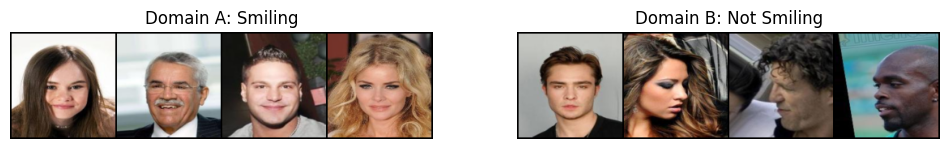

In [37]:
def show_samples(data_loader, num_samples=4):
    data = next(iter(data_loader))
    imgs_A = data['A'][:num_samples]
    imgs_B = data['B'][:num_samples]
    
    grid_A = make_grid(imgs_A, nrow=num_samples, normalize=True)
    grid_B = make_grid(imgs_B, nrow=num_samples, normalize=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(np.transpose(grid_A.numpy(), (1,2,0)))
    axs[0].set_title("Domain A: Smiling")
    axs[0].axis('off')
    
    axs[1].imshow(np.transpose(grid_B.numpy(), (1,2,0)))
    axs[1].set_title("Domain B: Not Smiling")
    axs[1].axis('off')
    
    plt.show()

show_samples(dataloader)

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(features)
        )
    
    def forward(self, x):
        return x + self.block(x)

class ResNetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_residuals=9):
        super(ResNetGenerator, self).__init__()
        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, kernel_size=7, padding=0),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(num_residuals):
            model += [ResidualBlock(in_features)]
        
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_features, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)


In [39]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_nc):
        super(PatchGANDiscriminator, self).__init__()
        # A sequence of convolutional layers
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        model += [
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Output layer
        model += [nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)


In [40]:
# Define input and output channels
input_nc = 3  # RGB images
output_nc = 3

# Initialize generators and discriminators
netG_A2B = ResNetGenerator(input_nc, output_nc).to(device)  # Generator A -> B
netG_B2A = ResNetGenerator(output_nc, input_nc).to(device)  # Generator B -> A

netD_A = PatchGANDiscriminator(input_nc).to(device)  # Discriminator for domain A
netD_B = PatchGANDiscriminator(output_nc).to(device)  # Discriminator for domain B

# Print model summaries
print(netG_A2B)
print(netD_A)


ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

In [41]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and m.weight is not None:
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)

# Apply the updated initialization
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)


PatchGANDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [42]:
# Define loss functions
criterion_GAN = nn.MSELoss().to(device)       # Least Squares GAN
criterion_cycle = nn.L1Loss().to(device)      # Cycle Consistency Loss
criterion_identity = nn.L1Loss().to(device)   # Identity Loss


In [43]:
# Define learning rates and other hyperparameters
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 200
lambda_cycle = 10.0
lambda_identity = 5.0

# Define optimizers
optimizer_G = optim.Adam(
    list(netG_A2B.parameters()) + list(netG_B2A.parameters()), 
    lr=lr, betas=(beta1, beta2)
)

optimizer_D_A = optim.Adam(netD_A.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=lr, betas=(beta1, beta2))

# Define learning rate schedulers
def lambda_rule(epoch):
    lr_l = 1.0 - max(0, epoch - 100) / float(100 + 1)
    return lr_l

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)
scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)


In [44]:
from collections import deque

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0,
        self.max_size = max_size
        self.data = deque(maxlen=max_size)
    
    def push_and_pop(self, data):
        to_return = []
        for element in data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if torch.rand(1).item() > 0.5:
                    idx = np.random.randint(0, self.max_size)
                    tmp = self.data[idx].clone()
                    self.data[idx] = element
                    to_return.append(tmp)
                else:
                    to_return.append(element)
        return torch.cat(to_return)

# Initialize buffers
buffer_A = ReplayBuffer()
buffer_B = ReplayBuffer()


In [45]:
def save_sample_images(epoch, generator, data_loader, device, output_dir='output'):
    os.makedirs(output_dir, exist_ok=True)
    data = next(iter(data_loader))
    real_A = data['A'].to(device)
    real_B = data['B'].to(device)
    
    # Generate fake images
    fake_B = generator['A2B'](real_A)
    fake_A = generator['B2A'](real_B)
    
    # Reconstruct images
    rec_A = generator['B2A'](fake_B)
    rec_B = generator['A2B'](fake_A)
    
    # Create a grid of images
    img_sample = torch.cat((real_A.data, fake_B.data, rec_A.data, real_B.data, fake_A.data, rec_B.data), 0)
    img_grid = make_grid(img_sample, nrow=real_A.size(0), normalize=True)
    
    # Save the image
    save_image(img_grid, os.path.join(output_dir, f'epoch_{epoch+1}.png'))


In [46]:
generator = {'A2B': netG_A2B, 'B2A': netG_B2A}
discriminator = {'A': netD_A, 'B': netD_B}


In [47]:
# Initialize lists to store loss values
G_losses = []
D_A_losses = []
D_B_losses = []
cycle_losses = []
identity_losses = []

# Number of total batches
total_steps = len(dataloader)

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, batch in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        # Set model input
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)
        
        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()
        
        # Identity loss
        # G_A2B(B) should be equal to B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B) * lambda_identity
        # G_B2A(A) should be equal to A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A) * lambda_identity
        
        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake_B = netD_B(fake_B)
        valid = torch.ones_like(pred_fake_B, device=device)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, valid)
        
        fake_A = netG_B2A(real_B)
        pred_fake_A = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake_A, valid)
        
        # Cycle consistency loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * lambda_cycle
        
        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * lambda_cycle
        
        # Total generators loss
        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB + loss_identity_A + loss_identity_B
        loss_G.backward()
        optimizer_G.step()
        
        ###### Discriminator A ######
        optimizer_D_A.zero_grad()
        
        # Real loss
        pred_real = netD_A(real_A)
        valid = torch.ones_like(pred_real, device=device)
        loss_D_real = criterion_GAN(pred_real, valid)
        
        # Fake loss
        fake_A_detached = fake_A.detach()
        pred_fake = netD_A(fake_A_detached)
        fake = torch.zeros_like(pred_fake, device=device)
        loss_D_fake = criterion_GAN(pred_fake, fake)
        
        # Total loss
        loss_D_A_total = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A_total.backward()
        optimizer_D_A.step()
        
        ###### Discriminator B ######
        optimizer_D_B.zero_grad()
        
        # Real loss
        pred_real = netD_B(real_B)
        valid = torch.ones_like(pred_real, device=device)
        loss_D_real = criterion_GAN(pred_real, valid)
        
        # Fake loss
        fake_B_detached = fake_B.detach()
        pred_fake = netD_B(fake_B_detached)
        fake = torch.zeros_like(pred_fake, device=device)
        loss_D_fake = criterion_GAN(pred_fake, fake)
        
        # Total loss
        loss_D_B_total = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B_total.backward()
        optimizer_D_B.step()
        
        ###### Logging ######
        G_losses.append(loss_G.item())
        D_A_losses.append(loss_D_A_total.item())
        D_B_losses.append(loss_D_B_total.item())
        cycle_losses.append((loss_cycle_ABA + loss_cycle_BAB).item())
        identity_losses.append((loss_identity_A + loss_identity_B).item())
        
        ###### Print Progress ######
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i+1}/{total_steps}] "
                  f"Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A_total.item():.4f} "
                  f"Loss_D_B: {loss_D_B_total.item():.4f}")
    
    ###### Update Learning Rates ######
    scheduler_G.step()
    scheduler_D_A.step()
    scheduler_D_B.step()
    
    ###### Save Sample Images ######
    if (epoch+1) % 10 == 0:
        save_sample_images(epoch, generator, dataloader, device)
    
    ###### Save Models ######
    if (epoch+1) % 50 == 0:
        os.makedirs('saved_models', exist_ok=True)
        torch.save(netG_A2B.state_dict(), f'saved_models/netG_A2B_epoch_{epoch+1}.pth')
        torch.save(netG_B2A.state_dict(), f'saved_models/netG_B2A_epoch_{epoch+1}.pth')
        torch.save(netD_A.state_dict(), f'saved_models/netD_A_epoch_{epoch+1}.pth')
        torch.save(netD_B.state_dict(), f'saved_models/netD_B_epoch_{epoch+1}.pth')


Starting Training Loop...


Epoch 1/200:   0%|▏                                                                 | 7/2647 [01:51<11:43:37, 15.99s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_A_losses, label="D_A")
plt.plot(D_B_losses, label="D_B")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
def display_generated_images(epoch, output_dir='output'):
    img_path = os.path.join(output_dir, f'epoch_{epoch+1}.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure(figsize=(12,12))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Generated Images at Epoch {epoch+1}')
        plt.show()
    else:
        print(f"No image found at {img_path}")
